# Prédiction de Salaires - Régression Linéaire Multiple

## Objectif
Ce notebook présente une analyse complète de régression linéaire multiple pour prédire les salaires des employés.

## Plan d'analyse
1. **Exploration des données**
2. **Préparation des données**
3. **Modélisation**
   - Baseline avec DummyRegressor
   - Régression linéaire simple
4. **Réugularisation avec GridSearchCV**
   - Ridge Regression (L2)
   - Lasso Regression (L1)
6. **Résumé et Comparaison Finale**

In [2]:
# Import des bibliothèques nécessaires
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve, validation_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

# Configuration de l'affichage
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

## 1. Chargement et Exploration des Données

In [3]:
# Chargement des données

# TO DO : Charger le dataset employee_salaries.csv dans un DataFrame pandas et afficher les 5 premières lignes ainsi que la shape du dataset
df = pd.read_csv('/Users/alicepastore/Downloads/ld/linear-regression-exercise/data/employee_salaries.csv')
print(df.head())
print(df.shape)


   age  experience  education_years  heures_semaine  nb_projets  \
0   38           5                0              39         3.0   
1   29           0                1              35         1.0   
2   25           1                0              37         0.0   
3   25           1                4              40         3.0   
4   37           5                1              41         7.0   

   evaluation_performance  anciennete_entreprise niveau_education departement  \
0                     2.9                      2              Bac   Marketing   
1                     4.6                      0              Bac     Finance   
2                     4.4                      0              Bac         R&D   
3                     7.4                      0           Master      Ventes   
4                     5.0                      0              Bac          IT   

    poste     ville   secteur  taille_entreprise  salaire_annuel  
0  Senior     Paris  Services  Grande Entre

In [4]:
# Informations sur le dataset et statistiques descriptives
print(df.info())
print(df.describe())
# TO DO : Afficher les informations statistiques sur le dataset ainsi que le nombre de valeurs manquantes par colonne
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   age                     10000 non-null  int64  
 1   experience              10000 non-null  int64  
 2   education_years         10000 non-null  int64  
 3   heures_semaine          10000 non-null  int64  
 4   nb_projets              9900 non-null   float64
 5   evaluation_performance  9800 non-null   float64
 6   anciennete_entreprise   10000 non-null  int64  
 7   niveau_education        10000 non-null  object 
 8   departement             10000 non-null  object 
 9   poste                   10000 non-null  object 
 10  ville                   10000 non-null  object 
 11  secteur                 10000 non-null  object 
 12  taille_entreprise       10000 non-null  object 
 13  salaire_annuel          10000 non-null  float64
dtypes: float64(3), int64(5), object(6)
memo

In [5]:
# Séparation des variables numériques et catégorielles


# TO DO : créer deux listes qui séparent les variables numériques et catégorielles
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df.select_dtypes(include=['object']).columns.tolist()
print("Variables numériques:", numeric_features)
print("Variables catégorielles:", categorical_features)



Variables numériques: ['age', 'experience', 'education_years', 'heures_semaine', 'nb_projets', 'evaluation_performance', 'anciennete_entreprise', 'salaire_annuel']
Variables catégorielles: ['niveau_education', 'departement', 'poste', 'ville', 'secteur', 'taille_entreprise']


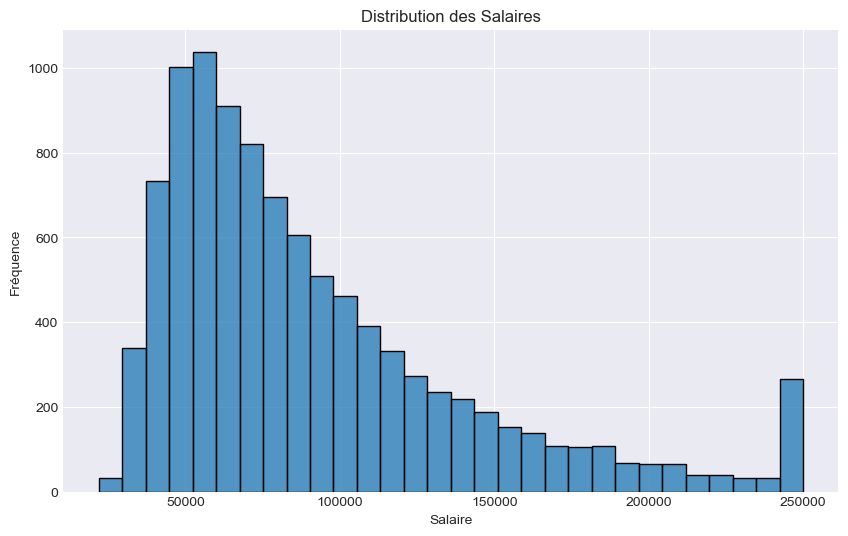

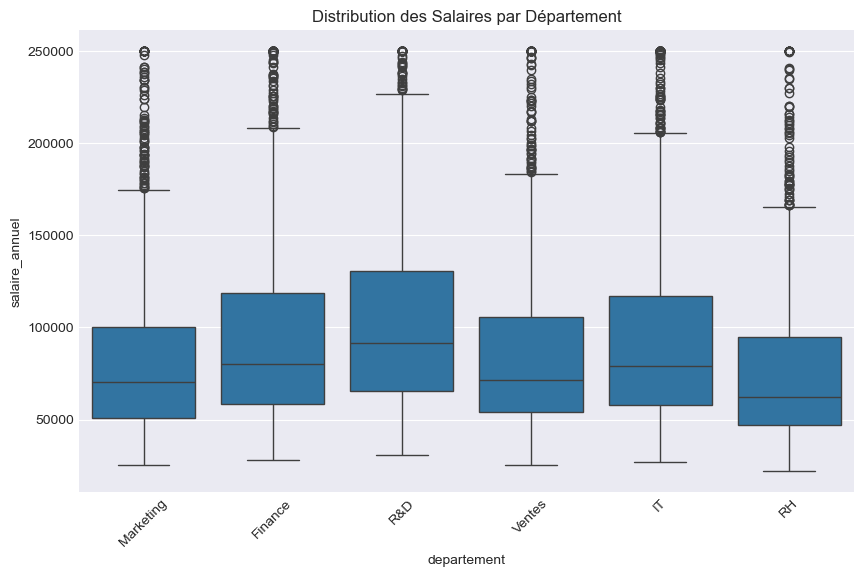

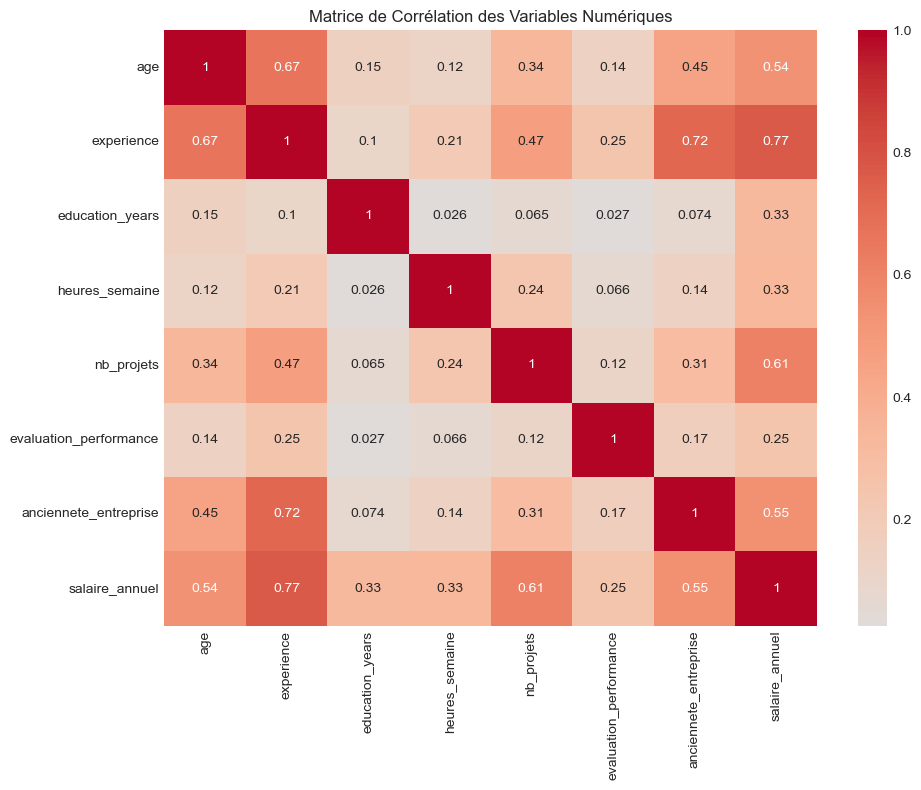

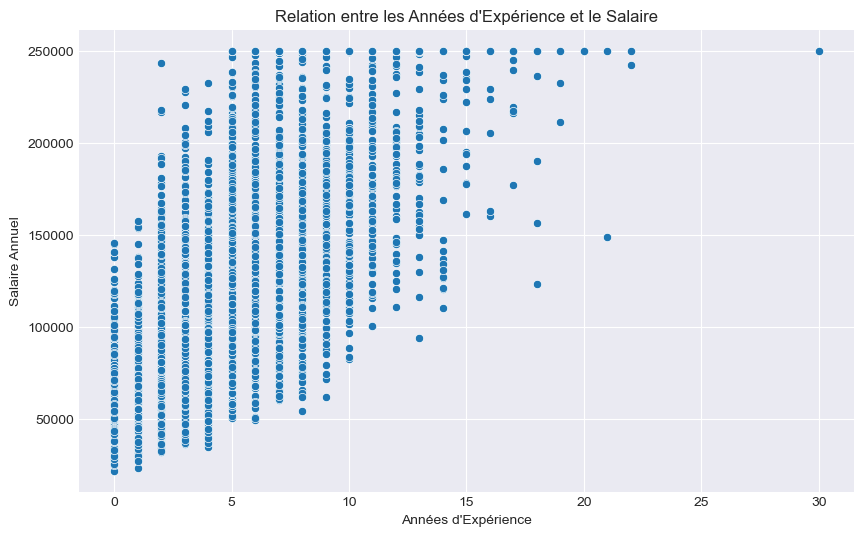

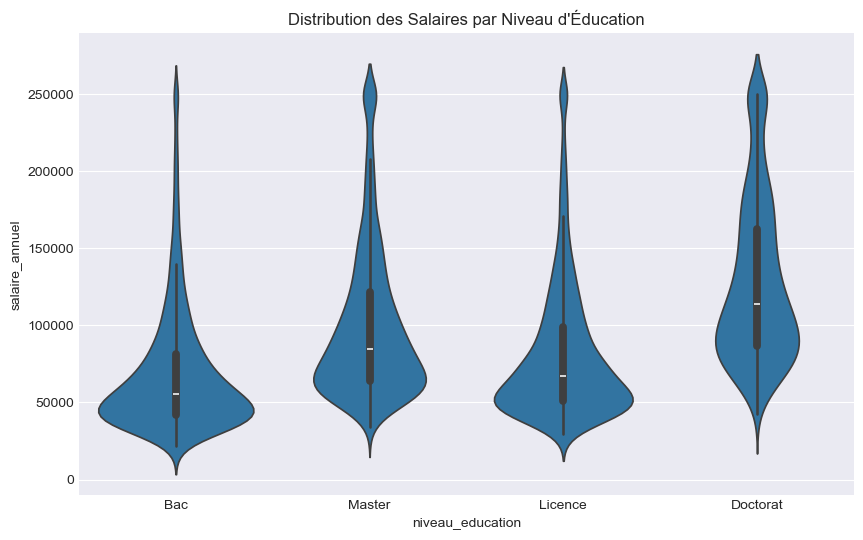

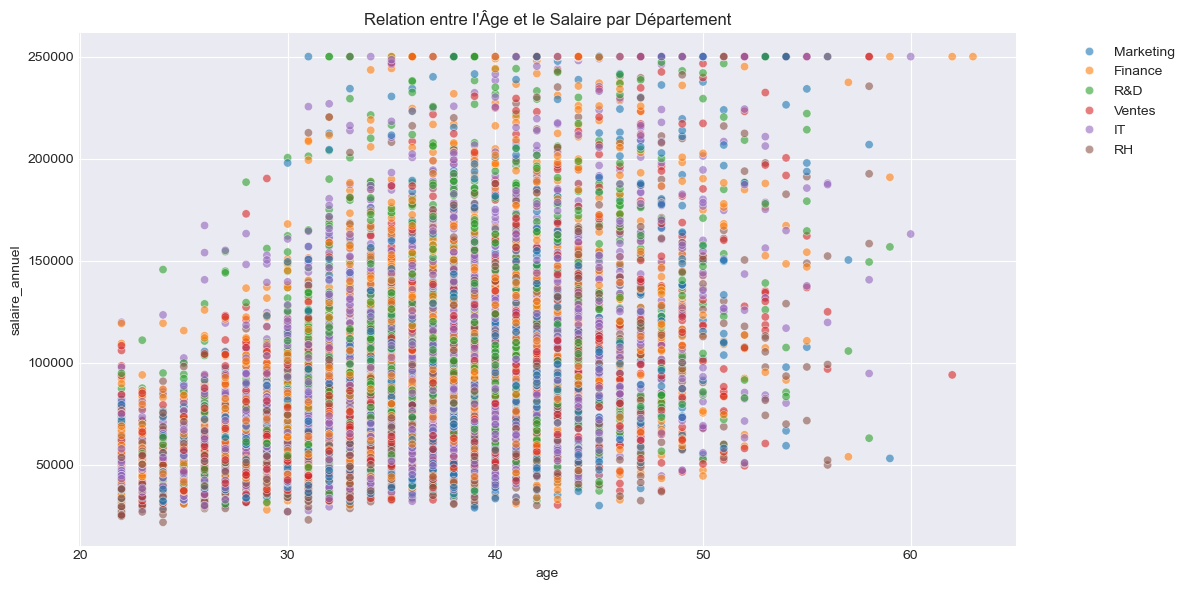

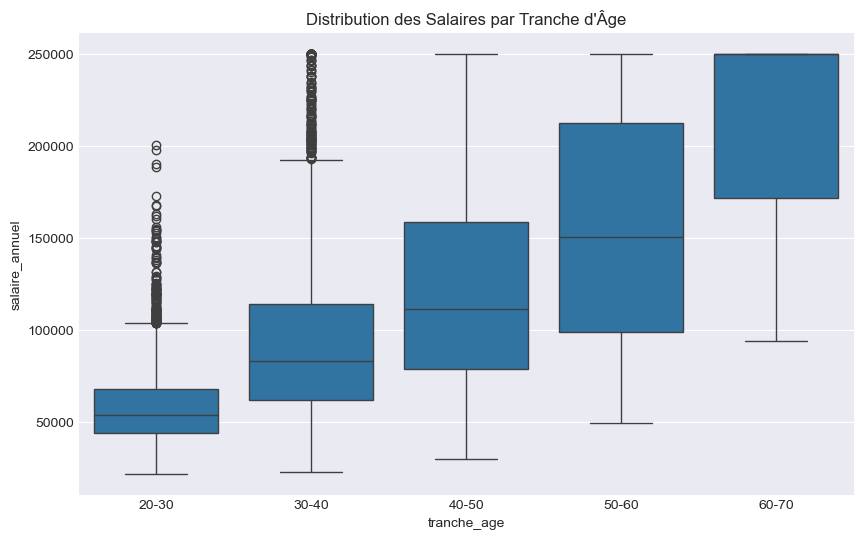

In [6]:
# Analyse des données
# TO DO : Analyser les données avec des visualisations appropriées (histogrammes, boxplots, heatmap de corrélation, etc.) 
# pour comprendre la distribution des variables et leurs relations avec la variable cible 'salaire'
# Distribution du salaire
plt.figure(figsize=(10, 6))
sns.histplot(x =df['salaire_annuel'], bins=30)
plt.title('Distribution des Salaires')
plt.xlabel('Salaire')
plt.ylabel('Fréquence')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='departement', y='salaire_annuel')
plt.xticks(rotation=45)
plt.title('Distribution des Salaires par Département')
plt.show()

# Matrice de corrélation pour les variables numériques
plt.figure(figsize=(10, 8))
sns.heatmap(df[numeric_features].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Matrice de Corrélation des Variables Numériques')
plt.tight_layout()
plt.show()


# Relation entre l'expérience et le salaire
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='experience', y='salaire_annuel')
plt.title('Relation entre les Années d\'Expérience et le Salaire')
plt.xlabel('Années d\'Expérience') 
plt.ylabel('Salaire Annuel')
plt.show()

# Distribution des salaires par niveau d'éducation
plt.figure(figsize=(10, 6))
sns.violinplot(data=df, x='niveau_education', y='salaire_annuel')
plt.title("Distribution des Salaires par Niveau d'Éducation")
plt.show()

# Relation entre l'âge et le salaire avec la couleur par département
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='age', y='salaire_annuel', hue='departement', alpha=0.6)
plt.title('Relation entre l\'Âge et le Salaire par Département')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Distribution des salaires par tranche d'âge
df['tranche_age'] = pd.cut(df['age'], bins=[20, 30, 40, 50, 60, 70], labels=['20-30', '30-40', '40-50', '50-60', '60-70'])
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='tranche_age', y='salaire_annuel')
plt.title('Distribution des Salaires par Tranche d\'Âge')
plt.show()



## 2. Préparation des Données

### 2.1 Séparation des features et de la cible

In [17]:
# Séparation des features (X) et de la cible (y)



# Séparer les données en dataset de features (X) et dataset de cible (y)
df_y = df['salaire_annuel']
df_X = df.drop(columns=['salaire_annuel'])


In [ ]:
# Division en ensemble d'entraînement et de test (80/20)

# Spliter les données en ensembles d'entraînement et de test (80/20) et utiliser l'arribut random_state=42 
df_y_train, df_y_test, df_X_train, df_X_test = train_test_split(df_y, df_X, test_size=0.2, random_state=42)

### 2.2 Preprocessing Pipeline

Nous allons créer un pipeline de preprocessing qui:
1. Impute les valeurs manquantes pour les variables numériques
2. Applique le scaling sur les variables numériques
3. Applique le one-hot encoding sur les variables catégorielles

In [ ]:
# TO DO : implémenter des stratégie de prétraitement des données numériques et catégorielles en utilisant ColumnTransformer et Pipeline


## 3. Modélisation

### 3.1 Modèle de Base - DummyRegressor

In [10]:
# TO DO : Entrainer un modèle DummyRegressor, qui servira de baseline, et évaluer ses performances sur l'ensemble de test

### 3.2 Régression Linéaire Simple

In [11]:
# TO DO : Entrainer un modèle de régression linaire

In [12]:
# TO DO : afficher les valeurs prédites par le modèle linéaire vs les valeurs réelles du dataset de test

In [13]:
# TO DO : afficher les valeurs des coefficients du modèle linéaire

## 4. Régularisation avec GridSearchCV

In [14]:
# TO DO : Entrainer un modèle Ridge en testant les hyerparamètres suivants : 
#    - 'alpha': np.logspace(-3, 2, 20),
#    - 'selection': ['cyclic', 'random']
# Afficher les résultats de la cross validation et les performances sur l'ensemble de test 

In [15]:
# TO DO : Entrainer un modèle Ridge en testant les hyerparamètres suivants : 
#    - 'alpha': np.logspace(-3, 3, 20),
#    - 'solver': ['auto', 'svd', 'cholesky', 'lsqr']
# Afficher les résultats de la cross validation et les performances sur l'ensemble de test

## 5. Résumé et Comparaison Finale

In [16]:
# TO : Afficher pour chaque modèle (dummy, linéaire, ridge, lasso) les performances sur l'ensemble d'entrainement et de test et conclure
# sur le choix du modèle et sa capacité de généralisation